# Dataset

In [2]:
import zipfile

!wget https://chitanka.info/text/4618-frankenshtajn.txt.zip

path = "4618-frankenshtajn.txt.zip"

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(".")
    
!mv "Mary-Shelley -  - . Frankenshtajn - 4618.txt" "dataset.txt"

!rm $path


--2024-09-21 23:14:11--  https://chitanka.info/text/4618-frankenshtajn.txt.zip
Resolving chitanka.info (chitanka.info)... 2a06:98c1:3120::2, 2a06:98c1:3121::2, 188.114.96.2, ...
Connecting to chitanka.info (chitanka.info)|2a06:98c1:3120::2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://m3.chitanka.info/text/4618-frankenshtajn.txt.zip?filename= [following]
--2024-09-21 23:14:11--  https://m3.chitanka.info/text/4618-frankenshtajn.txt.zip?filename=
Resolving m3.chitanka.info (m3.chitanka.info)... 2a06:98c1:3121::2, 2a06:98c1:3120::2, 188.114.96.2, ...
Connecting to m3.chitanka.info (m3.chitanka.info)|2a06:98c1:3121::2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /cache/dl/Mary-Shelley_-_Frankenshtajn_-_4618.txt.zip [following]
--2024-09-21 23:14:11--  https://m3.chitanka.info/cache/dl/Mary-Shelley_-_Frankenshtajn_-_4618.txt.zip
Reusing existing connection to [m3.chitanka.info]:443.
HTTP request sent, awaiting respon

In [3]:
with open("dataset.txt", "r") as f:
    text = f.read()

# Vocabulary

In [4]:
unique_chars = set(text)
sorted_chars = sorted(unique_chars)
sorted_chars
"".join(sorted_chars)

'\t\n !$()*,-./0123456789:;=?DIMNVX[]_abcdefghijkmnoprstuvx«»АБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЮЯабвгдежзийклмнопрстуфхцчшщъьюя–—“„…\ufeff'

# Tokenizer

In [25]:
encoding = { c: i for i, c in enumerate(sorted_chars) }

def encode(text: str):
    return [encoding[c] for c in text]

def test_encode():
    test_text = "франкейщайн!"
    test_encoding = encode(test_text)
    assert test_encoding[0] == encoding[test_text[0]]
    assert test_encoding[1] == encoding[test_text[1]]
    
# test_encode()

decoding = { i: c for i, c in enumerate(sorted_chars) }

test_text = "франкейщайн!"
test_encoding = encode(test_text)

def decode(arr):
    return "".join([decoding[t] for t in arr])

def test_decode():
    test_text = "франкейщайн!"
    assert decode(encode(test_text)) == test_text
    
# test_decode()

In [26]:
import torch

data = torch.tensor(encode(text))

data

tensor([120,   0,  69,  ...,  13,   1,   1])

In [27]:
train_data_size = round(len(data) * 0.9)

train_data = data[:train_data_size]

train_data

tensor([120,   0,  69,  ..., 102,  95,  99])

In [28]:
val_data = data[train_data_size:]

val_data

tensor([103,  99,   2,  ...,  13,   1,   1])

# Model input and output (output = input[last + 1])

In [29]:
context_length = 8

train_data[:context_length+1]

tensor([120,   0,  69,  90, 101,  93,   2,  81,  90])

In [30]:
model_input = train_data[:context_length]

model_input

tensor([120,   0,  69,  90, 101,  93,   2,  81])

In [31]:
decode(model_input.numpy().tolist())

'\ufeff\tМери Ш'

In [32]:
model_output = train_data[1:context_length+1]

model_output[-1]

tensor(90)

In [33]:
decode(model_output.numpy().tolist())[-1]

'е'

# Batch

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def get_batch(split: str, batch_size: int, context_length: int):
    batch_data = train_data if split == "train" else val_data
    ix = torch.randint(len(batch_data) - context_length, (batch_size,))

    x = torch.stack([batch_data[i:i+context_length] for i in ix])
        
    y = torch.stack([batch_data[i+1:i+context_length+1] for i in ix])
    
    x, y = x.to(device), y.to(device)
    
    return x, y

# Log loss

In [35]:
@torch.no_grad()
def estimate_loss(model, iterations, batch_size, context_length):
    estimation = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(iterations)
        for k in range(iterations):
            X, Y = get_batch(split, batch_size, context_length)
            X, Y = X.to(device), Y.to(device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        estimation[split] = losses.mean()
    model.train()
    return estimation

# Bigram model

In [43]:
import torch.nn as nn
import torch.nn.functional as F

vocabulary_size = len(sorted_chars) # unique chars in dataset

class BigramModel(nn.Module):
    def __init__(self, vocabulary_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocabulary_size, vocabulary_size)
        
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # returns (batch, time, channel) = (batch_size, context_length, vocabulary_size)
        
        if targets is None:
            loss = None
        else:        
            batch, time, channel = logits.shape
            
            logits = logits.view(batch * time, channel)
            targets = targets.view(batch * time)
            
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (batch_size, context_length) array of indices in the current context
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] # becomes (batch_size, channel)

            probs = F.softmax(logits, dim=-1) # (batch_size, channel)
            
            next_idx = torch.multinomial(probs, num_samples=1) # (batch_size, 1)
            
            idx = torch.cat((idx, next_idx), dim=1) # (batch_size, context_length + 1)
        return idx
    
m = BigramModel(vocabulary_size)

model = m.to(device)

idx = torch.zeros((1, 1), dtype=torch.long, device=device)

generated = model.generate(idx, max_new_tokens=100)[0].tolist()

print(decode(generated)) # ~ random generation, model not trained

	аШкУ„﻿agюлщ–ихфкДТзГ„ц5ДИ=$,aКДщhРжж4]сШDи6ъЩD.,(чмр/?taГ﻿ИПkш-П-9…)(хщb–u“;па;н«гнв;ЖЗ﻿нNюcsXxщ=jБD


# Bigram model training

In [44]:
def train_bigram_model(max_iterations=10000, iterations_interval=100, eval_iterations=50, batch_size=32, learning_rate=1e-3, model=model, context_length=8):
    train_losses = []
    val_losses = []
    steps = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for iteration in range(max_iterations):
        if iteration % iterations_interval == 0:
            losses = estimate_loss(model, eval_iterations, batch_size, context_length)
            print(f"step {iteration}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            steps.append(iteration)
            
        xb, yb = get_batch("train", batch_size, context_length)
        
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
    return train_losses, val_losses, steps

step 0: train loss 5.1030, val loss 5.0883
step 100: train loss 4.9780, val loss 4.9693
step 200: train loss 4.8544, val loss 4.8376
step 300: train loss 4.7154, val loss 4.7216
step 400: train loss 4.6191, val loss 4.5889
step 500: train loss 4.4895, val loss 4.4855
step 600: train loss 4.3831, val loss 4.3664
step 700: train loss 4.2688, val loss 4.2450
step 800: train loss 4.1615, val loss 4.1444
step 900: train loss 4.0569, val loss 4.0463
step 1000: train loss 3.9780, val loss 3.9607
step 1100: train loss 3.8901, val loss 3.8532
step 1200: train loss 3.8104, val loss 3.7835
step 1300: train loss 3.6939, val loss 3.7100
step 1400: train loss 3.6322, val loss 3.6166
step 1500: train loss 3.5548, val loss 3.5418
step 1600: train loss 3.4943, val loss 3.4924
step 1700: train loss 3.4293, val loss 3.4134
step 1800: train loss 3.3516, val loss 3.3513
step 1900: train loss 3.2872, val loss 3.2767
step 2000: train loss 3.2320, val loss 3.2510
step 2100: train loss 3.2010, val loss 3.1932


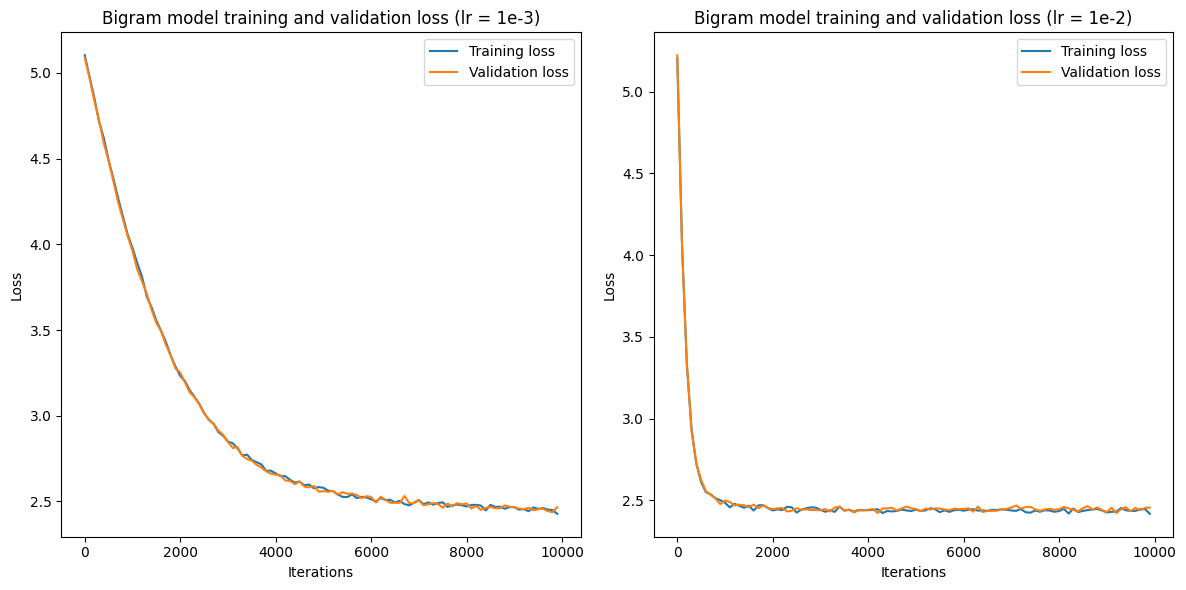

In [45]:
import matplotlib.pyplot as plt

train_losses, val_losses, steps = train_bigram_model()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(steps, train_losses, label="Training loss")
ax1.plot(steps, val_losses, label="Validation loss")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.set_title("Bigram model training and validation loss (lr = 1e-3)")
ax1.legend()

m = BigramModel(vocabulary_size)

model = m.to(device)

train_losses, val_losses, steps = train_bigram_model(learning_rate=1e-2, model=model)

ax2.plot(steps, train_losses, label="Training loss")
ax2.plot(steps, val_losses, label="Validation loss")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_title("Bigram model training and validation loss (lr = 1e-2)")
ax2.legend()
plt.tight_layout()
plt.show()

In [49]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)

generated = model.generate(idx, max_new_tokens=300)[0].tolist()

print(decode(generated))

	Стастаро о бя ва мият.
	Тямеотияхо съмак по, Сле еля намедне, ри а не сайт м се побечих.
	Ере обетве, сълосъламе бще овуспроскъра пе се сумъдена на азви веледяз наше и соблетето м, — т надаме кияк; ма, мявикотятот но и ни те погаведъряко Са бе ланилите нада ра аша детиди о-ханактозатова побякако ста
